C:\Users\tina\Desktop\DATS 6501 - Capstone Project - Tina Nguyen\02. Data\Sample Data
['historical_data1_Q12013.txt', 'historical_data1_Q22013.txt', 'historical_data1_time_Q12013.txt', 'historical_data1_time_Q22013.txt', 'sample.csv']
(184942, 30)
Index(['id_loan', 'cr_scr', 'frst_pmt', 'frst_homebuyer', 'mtry_date', 'MSA',
       'MI_pct', 'unit', 'occ_sts', 'cltv', 'dti', 'upb', 'ltv',
       'interest_rate', 'channel', 'ppty_state', 'ppty_type', 'pstl_code',
       'loan_prps', 'term', 'total_borr', 'slr', 'srvc', 'cnfm_flag', '_merge',
       'Year', 'YrQtr', 'default', 'Rate', 'sato'],
      dtype='object')


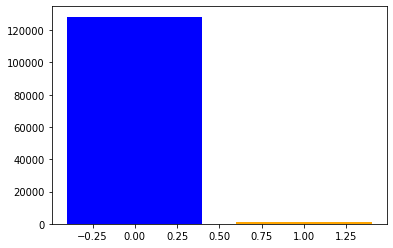

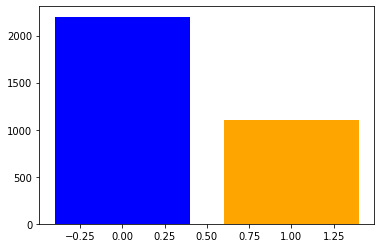

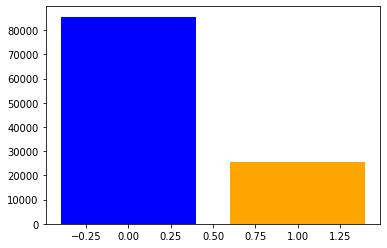

BASE MODEL:
LogisticRegression 
 Training 
 Accuracy: 0.9915031013680007 ROC AUC: 0.5 
 Precision Recall fscore support (0.9915031013680007, 1.0, 0.9957334243536138, None)
LogisticRegression 
 Testing 
 Accuracy: 0.9914748661752248 ROC AUC: 0.4999909109087273 
 Precision Recall fscore support (0.49574636819148554, 0.4999909109087273, 0.49785959291538834, None)

-----------------------------------------------------

DecisionTreeClassifier 
 Training 
 Accuracy: 0.7604878764705428 ROC AUC: 0.8634449084209131 
 Precision Recall fscore support (0.5164417756145413, 0.8634449084209133, 0.46347320368691625, None)
DecisionTreeClassifier 
 Testing 
 Accuracy: 0.7536722960186003 ROC AUC: 0.6489290739694896 
 Precision Recall fscore support (0.5067530779099945, 0.6489290739694896, 0.4474513797398503, None)

-----------------------------------------------------

XGBClassifier 
 Training 
 Accuracy: 0.9919820174727134 ROC AUC: 0.5281818181818182 
 Precision Recall fscore support (0.9959890878459314

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from collections import Counter


DIR = os.path.join( os.path.dirname(os.getcwd()))
DATA_DIR = os.path.join(DIR ,'02. Data')
SAMPLE_DIR = DATA_DIR + '\Sample Data'
print(SAMPLE_DIR)
print(os.listdir(SAMPLE_DIR))
# IMPORT DATA

master_df = pd.read_csv(os.path.join(SAMPLE_DIR, 'sample.csv'))
print(master_df.shape)
print(master_df.columns)

# PREPARING DATA
# drop unnecessary columns (identifier, time, location, etc.)
X = master_df.drop(['default','_merge','Year','id_loan','frst_pmt','mtry_date','MSA','pstl_code', 'YrQtr', 'Rate', 'slr', 'srvc'], axis=1)
y = master_df['default']

# summary statistics
stat = X[['ltv', 'dti', 'sato', 'interest_rate','cr_scr','MI_pct']].describe()
stat.to_csv(os.path.join(SAMPLE_DIR, 'summary statistics.csv'))

# convert categorical variables to dummy
X = pd.get_dummies(X)
# standardize the data
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
# use LabelEncoder to encode the default variable
class_le = LabelEncoder()
y = class_le.fit_transform(y)
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# resample the training dataset to different sizes
undersample50 = RandomUnderSampler(sampling_strategy=0.5)
X_under50, y_under50 = undersample50.fit_resample(X_train, y_train)

# oversample 20%, undersample 30%
oversample = RandomOverSampler(sampling_strategy=0.2)
undersample50 = RandomUnderSampler(sampling_strategy=0.3)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_combine, y_combine = undersample50.fit_resample(X_over, y_over)

# plot class distribution for each population
def plotData(data):
    c = Counter(data)
    plt.bar(c.keys(), c.values(), color = ['blue', 'orange'])
    plt.show()


for i in [y_train, y_under50, y_combine]:
    plotData(i)
    plt.show()

# TRAINING

# function to print out the score of each iteration
def prediction_score(clf_name,session_name,y, pred):
    print(clf_name,'\n',session_name,'\n Accuracy:',accuracy_score(y, pred),
         'ROC AUC:',roc_auc_score(y, pred), '\n',
         'Precision Recall fscore support',precision_recall_fscore_support(y, pred, average='macro', labels=np.unique(pred)))


# function to declare and train different models
def classification_balanced(train_X, train_y, test_X, test_y):
    # declare the classifers
    lr_clf = LogisticRegression(random_state=42)
    xg_clf = XGBClassifier(random_state=42)  #(learning_rate=0.05, n_estimators=300, max_depth=5)
    dt_clf = DecisionTreeClassifier(class_weight='balanced', max_features=50, min_samples_leaf=100, min_samples_split=10, random_state=42)
    start_time = time.time()
    for clf in (lr_clf, dt_clf, xg_clf):

        clf.fit(train_X, train_y) # fit the model
        y_pred_train = clf.predict(train_X)  # make preidiction on the training set
        y_pred_test = clf.predict(test_X)  # make prediction on the testing set

        # apply the scoring function
        prediction_score(clf.__class__.__name__, 'Training', train_y, y_pred_train)
        prediction_score(clf.__class__.__name__, 'Testing', test_y, y_pred_test)

        print()
        print('-----------------------------------------------------')
        print()
    print("--- %s seconds ---" % (time.time() - start_time))


# fit the model on the full population X_train, y_train
print('BASE MODEL:')
classification_balanced(X_train, y_train, X_test, y_test)
print('___________________________________________________________________')

# fit the model on reduced data
print('UNDERSAMPLING 50%:')
classification_balanced(X_under50, y_under50, X_test, y_test)
print('___________________________________________________________________')

# fit the model on combined data
print('COMBINE:')
classification_balanced(X_combine, y_combine, X_test, y_test)
print('___________________________________________________________________')

